### Dummy Train to Overfit

In [2]:
from utility.utils import *
from dataset.dataset import *
from dataset.transform import *
from model.loss import *
from model.unet import UNet256_3x3
from training.classifier import NucleiClassifier
from model.eval import create_validation_dirs, show_predictions
from dataset.submission import *

import torch
from torch.autograd import Variable as V
import torch.nn.functional as F
import torch.optim as optim

from skimage.morphology import label
from collections import OrderedDict
import matplotlib.pyplot as plt
import cv2
import shutil
import os

### Create Random Train and Validation Set

In [3]:
main_path = '../data/ds_bowl_2018/'
full_path = '../data/ds_bowl_2018/full_data/'

In [4]:
create_validation_dirs(main_path, full_path, 0.90)

Copied 603 training and 67 validation data


### Training

In [5]:
train_path = '../data/ds_bowl_2018/train/'
valid_path = '../data/ds_bowl_2018/valid/'

c15c652c08153fb781a5349123ab8f80bb2a8680a41eb8e89e547ae01b7a5441.png


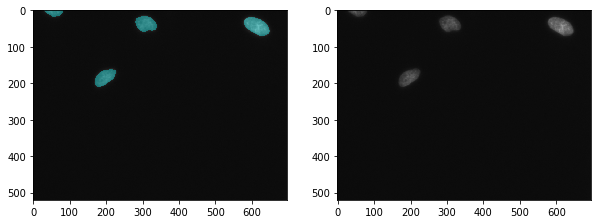

d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0.png


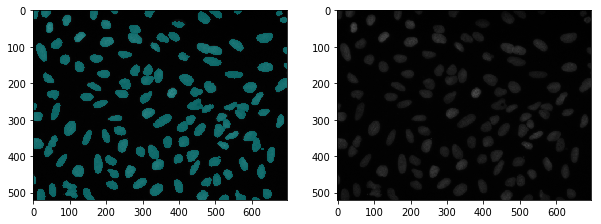

942d56861fc83e195e9c559a000bb86627d8682f8dcc2300818458e5b6850dd0.png


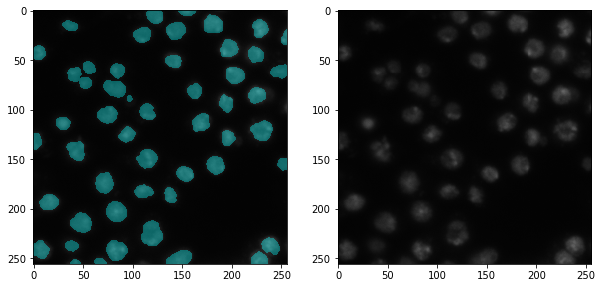

c53326fe49fc26b7fe602b9d8c0c2da2cb157690b44c2b9351a93f8d9bd8043d.png


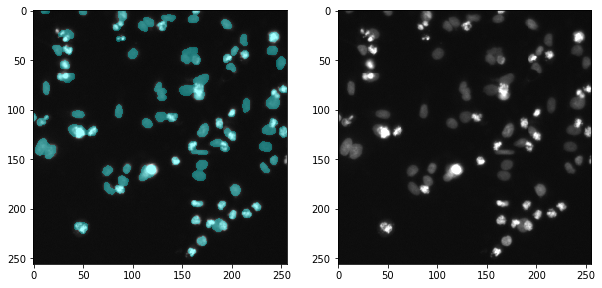

ad473063dab4bf4f2461d9a99a9c0166d4871f156516d9e0a523484e7cf2258d.png


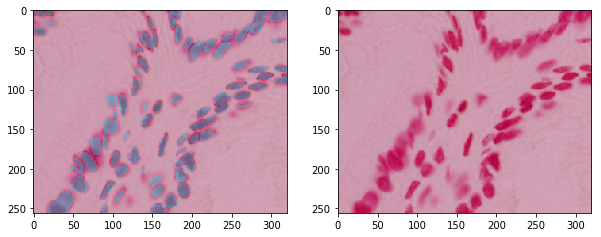

In [6]:
# Look at training images
image_mask_paths = get_image_onemask_paths(train_path)
for img_path , mask_path in image_mask_paths[:5]:
    show_image(img_path, mask_path, figsize=(10, 10))

3b957237bc1e09740b58a414282393d3a91dde996b061e7061f4198fb03dab2e.png


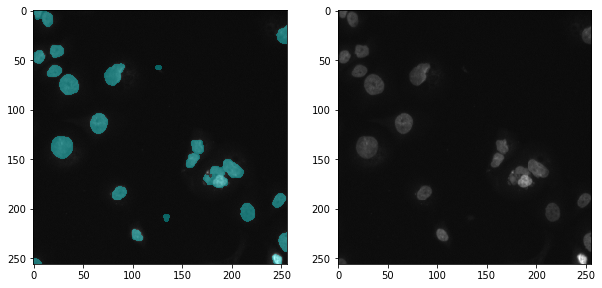

94519eb45cbe1573252623b7ea06a8b43c19c930f5c9b685edb639d0db719ab0.png


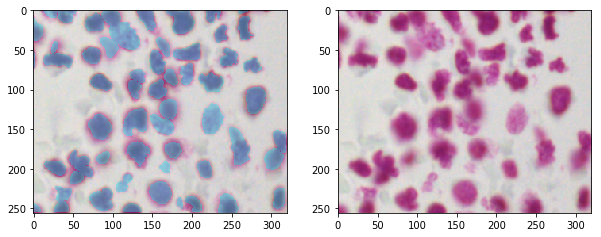

ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5f5dd2ddfe5407007ee.png


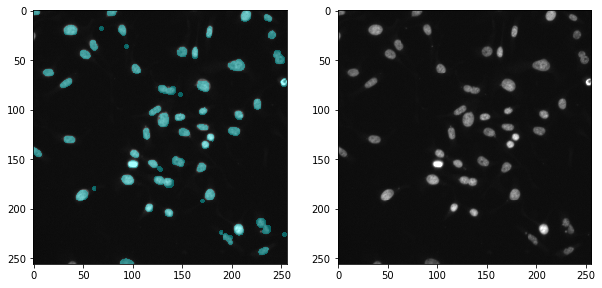

bf4a61bb81589c9a67e3343408befd3e135af5e88b50c17f998f2131d24bc271.png


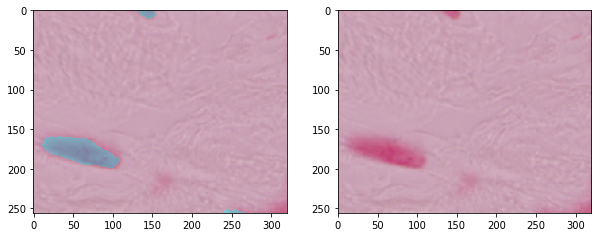

8e507d58f4c27cd2a82bee79fe27b069befd62a46fdaed20970a95a2ba819c7b.png


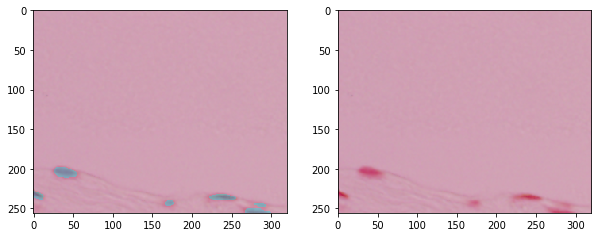

In [7]:
# Look at validation images
image_mask_paths = get_image_onemask_paths(valid_path)
for img_path , mask_path in image_mask_paths[:5]:
    show_image(img_path, mask_path, figsize=(10, 10))

### Training

In [8]:
def augment(image, mask, index, sz = 256):        
    # do some data augmentation
    image, mask = random_horizontal_flip_transform2(image, mask)
    image, mask = random_vertical_flip_transform2(image, mask)
    image, mask = random_rotate_transform2(image, mask)
    image, mask = random_crop_resize2(image, mask, 0.1)
    
    # resize image for Unet256
    image, mask = fix_resize_transform2(image, mask, sz, sz)
    
    # normalize pixel intensities 
    # get dimensions right
    image = (image.transpose((2,0,1))) / 255 
    mask = mask[None, :] / 255 
    
    return image.astype(np.float64), mask.astype(np.float64), index

In [9]:
# create trainloader
trn_ds = NucleiDataset(train_path, transform=augment, mode='train')
trn_dl = DataLoader(trn_ds, batch_size=16, shuffle=True)
# create validloader
val_ds = NucleiDataset(valid_path, transform=augment, mode='valid')
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [10]:
# training definition
net = UNet256_3x3(in_shape=(3, 256, 256), num_classes=1).double()
#optimizer = optim.Adam(net.parameters(), lr=0.1)
optimizer = optim.RMSprop(net.parameters())

In [12]:
# init classifier
classifier = NucleiClassifier(net, 1000)

In [13]:
# train for 10 epochs
classifier.train(train_loader=trn_dl, valid_loader=val_dl, optimizer=optimizer, epochs=50, threshold=0.5)

Epoch: 1
Training : [0.8358 , 0.5332],Validation : [0.7242 , 0.5967]
Epoch: 2
Training : [0.6331 , 0.6706],Validation : [0.5804 , 0.6476]
Epoch: 3
Training : [0.5369 , 0.7233],Validation : [0.55 , 0.7041]
Epoch: 4
Training : [0.4639 , 0.7796],Validation : [0.4484 , 0.7932]
Epoch: 5
Training : [0.405 , 0.801],Validation : [0.613 , 0.5445]
Epoch: 6
Training : [0.4329 , 0.785],Validation : [0.356 , 0.8239]
Epoch: 7
Training : [0.3495 , 0.8273],Validation : [1.665 , 0.5603]
Epoch: 8
Training : [0.3457 , 0.8243],Validation : [0.2962 , 0.8736]
Epoch: 9
Training : [0.3123 , 0.8532],Validation : [0.3275 , 0.8466]
Epoch: 10
Training : [0.3037 , 0.8499],Validation : [0.3722 , 0.7673]
Epoch: 11
Training : [0.3815 , 0.8093],Validation : [0.3586 , 0.8081]
Epoch: 12
Training : [0.3196 , 0.8521],Validation : [1.0474 , 0.4395]
Epoch: 13
Training : [0.2936 , 0.8586],Validation : [0.3637 , 0.8139]
Epoch: 14
Training : [0.2658 , 0.8736],Validation : [0.4322 , 0.8118]
Epoch: 15
Training : [0.284 , 0.857],

In [14]:
classifier.save_model('../data/ds_bowl_2018/models/unet256_model50', '../data/ds_bowl_2018/models/unet256_optim50')

### Visualize Evaluation

In [16]:

def show_predictions(dataloader, classifier, threshold=0.5, n=None):
    print('\t\t Image \t\t\t\t\t Mask \t\t\t\t Predicted Mask')
    for i, (img, msk, _ )in enumerate(iter(dataloader)):
        plt.figure(figsize=(20, 20))
        if torch.cuda.is_available:
            img = img.cuda()
        out = classifier.net(V(img))
        plt.subplot(1,3,1)
        plt.imshow(img.cpu().numpy()[0].transpose(1,2,0))
        plt.subplot(1,3,2)
        plt.imshow(msk.cpu().numpy()[0, 0])
        plt.subplot(1,3,3)
        plt.imshow((F.sigmoid(out).cpu().data.numpy()[0, 0] > threshold)*1)
        plt.show()
        i += 1
        if n:
            if n == i:
                break

		 Image 					 Mask 				 Predicted Mask


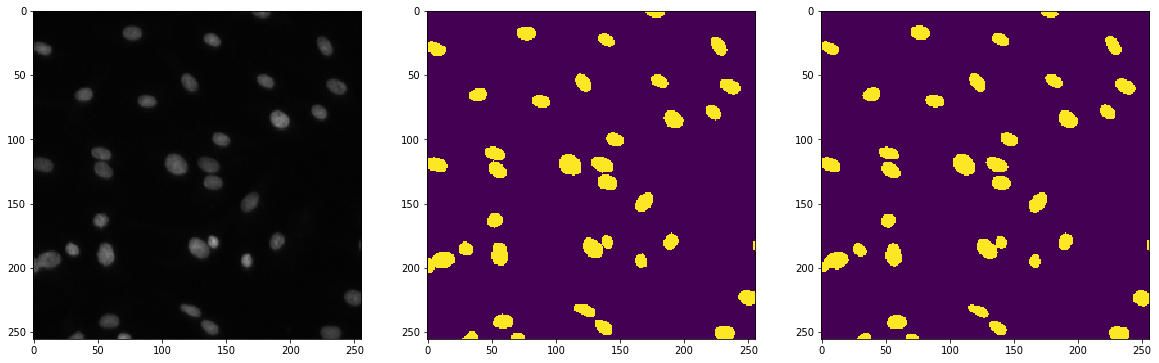

In [17]:
show_predictions(trn_dl, classifier, 0.5, 1)

		 Image 					 Mask 				 Predicted Mask


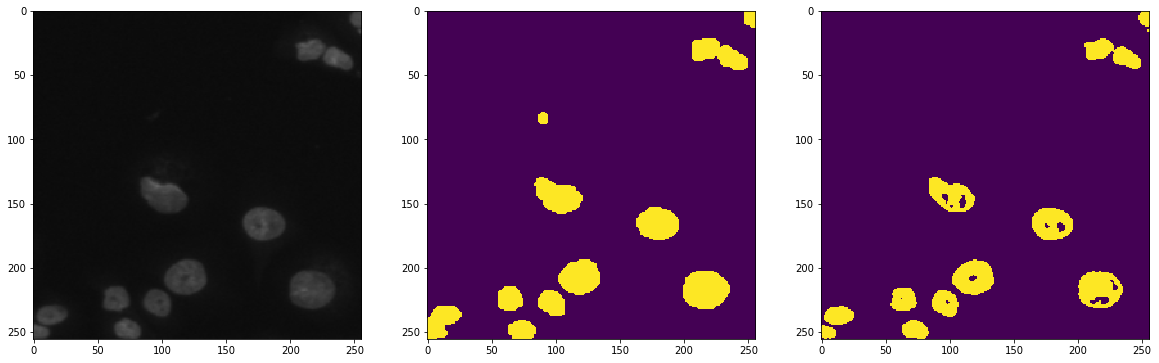

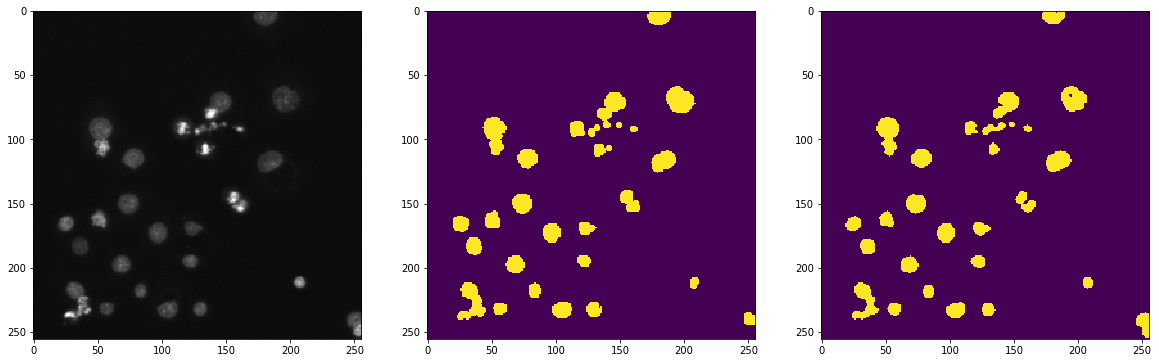

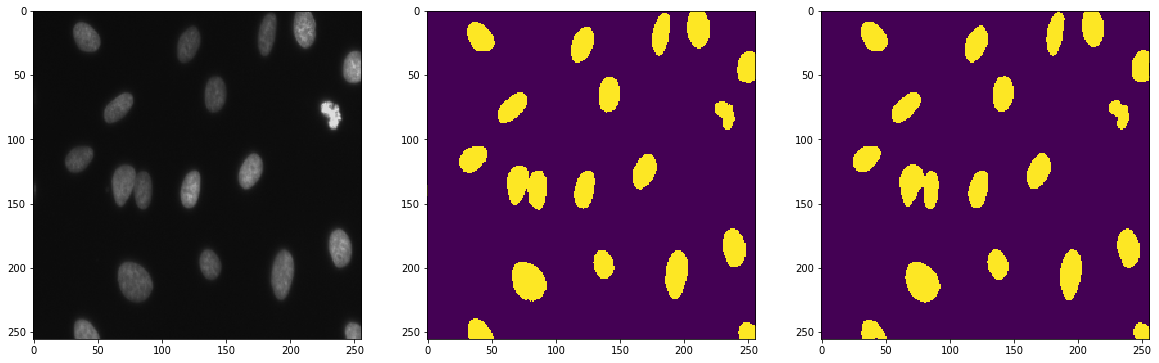

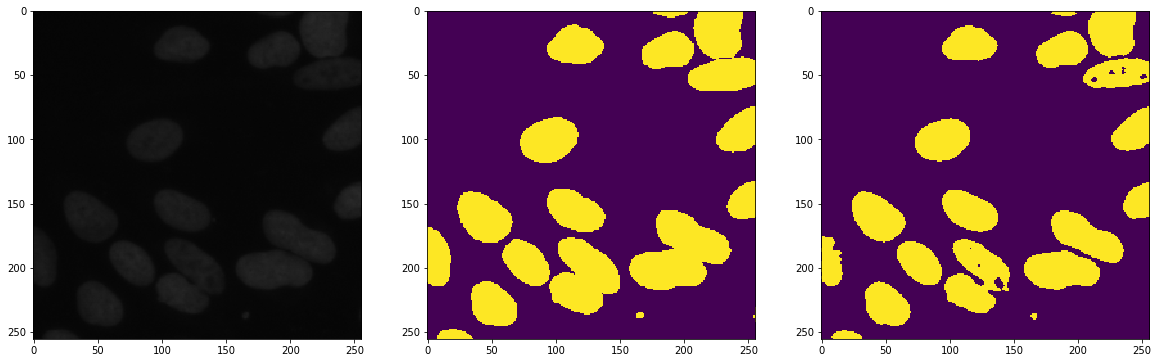

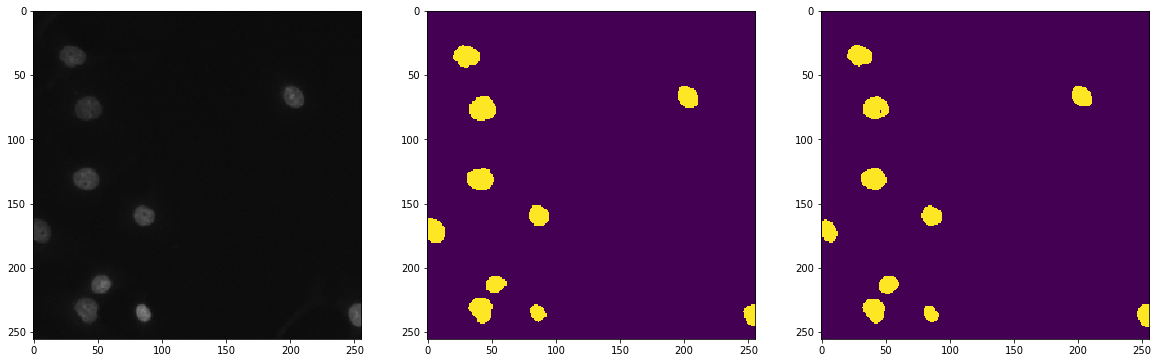

In [20]:
show_predictions(val_dl, classifier, 0.5, n=10)

### Make Predictions

In [23]:
def test_augment(image, mask, index, sz = 256):
    # resize image for Unet256
    image = fix_resize_transform(image, sz, sz)
    # normalize pixel intensities
    image = (image.transpose((2,0,1))) / 255 
    return image.astype(np.float64), index

In [24]:
# create trainloader
test_ds = NucleiDataset('../data/ds_bowl_2018/test/', transform=test_augment, mode='test')
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

In [25]:
preds = classifier.predict(test_dl)

In [26]:
test_ds.__getitem__(1)[1]

'ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8'

In [27]:
img = plt.imread('../data/ds_bowl_2018/test/ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8/images/ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8.png')

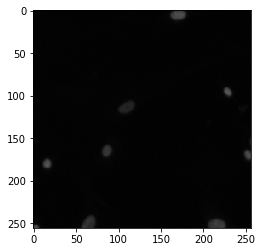

In [28]:
plt.imshow(img)

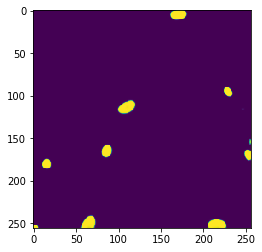

In [29]:
plt.imshow(preds[1][0, 0])

In [31]:
label((preds[1][0, 0] > 0.5))

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [10, 10, 10, ...,  0,  0,  0],
       [10, 10, 10, ...,  0,  0,  0],
       [10, 10, 10, ...,  0,  0,  0]])

In [32]:
np.unique(label((preds[1][0, 0] > 0.5)))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [33]:
train_labels = pd.read_csv('../data/ds_bowl_2018/csv/stage1_train_labels.csv')

In [34]:
id0 =  np.unique(train_labels.ImageId)[0]
len(train_labels[train_labels.ImageId == id0])

27

In [35]:
img = cv2.imread('../data/ds_bowl_2018/train/' + id0 + '/one_mask.png', cv2.IMREAD_GRAYSCALE)

In [36]:
np.unique(label(img, 8, connectivity=0))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

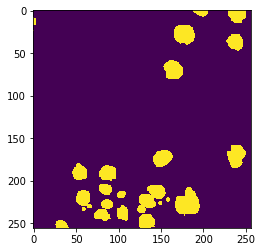

In [37]:
plt.imshow(img)

In [43]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [44]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ds.image_dirs):
    id_ = id_.split('/')[-2]
    rle = list(prob_to_rles(preds[n][0,0]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [45]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('../data/ds_bowl_2018/submissions/unet_basic.csv', index=False)

In [46]:
from IPython.display import FileLink

In [47]:
FileLink('../data/ds_bowl_2018/submissions/unet_basic.csv')

/home/ubuntu/deeplearning/data/ds_bowl_2018/submissions/unet_basic.csv